In [5]:
import sys

import numpy as np
import xml.etree.ElementTree as ET
from xml.dom import minidom
import subprocess
import sumolib
import copy
import matplotlib.pyplot as plt
from co2Emissions.xmlreader import main
import pickle

In [6]:
def eps_greedy_policy(q, actions, trip, original_costs, Incentives, epsilon=0.1):
    costs = copy.deepcopy(original_costs)
    if np.random.binomial(1, epsilon) == 1:
        action_index = (
            np.random.randint(len(costs[trip])),
            np.random.randint(len(Incentives)),
        )
    else:
        action_index = np.unravel_index(np.argmax(q[trip]), np.shape(q[trip]))

    if Incentives[action_index[1]] > 0:
        incentive = costs[trip][action_index[0]] - min(costs[trip]) + 1
    else:
        incentive = 0
    costs[trip][action_index[0]] -= incentive

    action = np.argmin(costs[trip])
    a = actions[trip][action][1]
    return a, action, action_index, incentive


def step(actions):
    write_routes(actions)
    write_edge_data_config("edge_data.add.xml", 500, "weights.xml")
    write_sumo_config(
        "config.sumocfg",
        "kamppi.net.xml",
        "output.rou.xml",
        "weights.xml",
        "edge_data.add.xml",
    )
    run_simulation()
    tot_emission = main("fcd.xml")

    return (
        (get_TTT() / (60**2)),
        normalise_dict(travelTimes()),
        normalise_dict(emissions_func()),
        normalise_scalar(300, 330, tot_emission / 1000),
    )


def get_actions(file="output.rou.alt.xml"):
    tree = ET.parse(file)
    root = tree.getroot()

    # Initialize the dictionary to store the data
    vehicle_routes = {}
    W = []
    route_costs = {}

    # Iterate over each vehicle element
    for vehicle in root.findall("vehicle"):
        vehicle_id = vehicle.get("id")
        W.append(vehicle_id)
        routes = []
        route_cost = []
        # Find routeDistribution within the vehicle
        route_distribution = vehicle.find("routeDistribution")
        if route_distribution:
            # Iterate over each route element within the routeDistribution
            for i, route in enumerate(route_distribution.findall("route")):
                edges = route.get("edges").split()
                routes.append((i, edges))
                route_cost.append(float(route.get("cost")))

        vehicle_routes[vehicle_id] = routes
        route_costs[vehicle_id] = route_cost
    return vehicle_routes, W, route_costs


def run_simulation():
    sys.stdout = sumolib.TeeFile(sys.stdout, open("log.xml", "w+"))
    log = open("log.xml", "w+")

    log.flush()
    sys.stdout.flush()

    sumo_cmd = ["sumo", "-c", "config.sumocfg"]

    sumo_cmd = list(map(str, sumo_cmd))
    subprocess.call(sumo_cmd, stdout=log, stderr=log)

    # self.TTTs.append(self.parse_tripinfo('tripinfo.xml'))


def write_sumo_config(filename, net_file, route_files, weight_file, additional_files):
    sumo_cmd = [
        "sumo",
        "-n",
        net_file,
        "-r",
        route_files,
        "--save-configuration",
        filename,
        "--edgedata-output",
        weight_file,
        "--tripinfo-output",
        "tripinfo.xml",
        "--log",
        "log.xml",
        "--no-step-log",
        "--additional-files",
        additional_files,  #'edge_data.add.xml',
        "--begin",
        "0",
        "--route-steps",
        "200",
        "--time-to-teleport",
        "300",
        "--time-to-teleport.highways",
        "0",
        "--no-internal-links",
        "False",
        "--eager-insert",
        "False",
        "--verbose",
        "True",
        "--no-warnings",
        "True",
        "--statistic-output",
        "stats.xml",
        "--fcd-output",
        "fcd.xml",
        "--fcd-output.acceleration",
    ]
    subprocess.call(sumo_cmd, stdout=subprocess.PIPE)


def write_edge_data_config(filename, freq, file):
    # Create the root element
    root = ET.Element("a")

    # edgeData element
    edge_data_elem = ET.SubElement(
        root,
        "edgeData",
        {
            "id": "edge_data",
            "freq": str(freq),
            "file": file,
            "excludeEmpty": "True",
            "minSamples": "1",
        },
    )

    # Create the XML tree
    tree = ET.ElementTree(root)

    # Convert to string
    xml_str = ET.tostring(root, encoding="unicode")

    # Parse the string with minidom for pretty printing
    pretty_xml_str = minidom.parseString(xml_str).toprettyxml(indent="    ")

    # Write to file
    with open(filename, "w", encoding="utf-8") as file:
        file.write(pretty_xml_str)


def write_routes(vehicle_routes, file="output.rou.xml"):
    # Create the root element
    routes_element = ET.Element("routes")
    routes_element.set("xmlns:xsi", "http://www.w3.org/2001/XMLSchema-instance")
    routes_element.set(
        "xsi:noNamespaceSchemaLocation", "http://sumo.dlr.de/xsd/routes_file.xsd"
    )

    # Add the vType element
    vtype_element = ET.SubElement(routes_element, "vType")
    vtype_element.set("id", "type1")
    vtype_element.set("length", "5.00")
    vtype_element.set("maxSpeed", "40.00")
    vtype_element.set("accel", "0.4")
    vtype_element.set("decel", "4.8")
    vtype_element.set("sigma", "0.5")

    # Add vehicles and their routes to the XML
    counter = 0
    for vehicle_id, edges in vehicle_routes.items():
        vehicle_element = ET.SubElement(routes_element, "vehicle")
        vehicle_element.set("id", vehicle_id)
        vehicle_element.set("type", "type1")
        vehicle_element.set(
            "depart", str(0.09 * counter)
        )  # Modify departure time as needed

        route_element = ET.SubElement(vehicle_element, "route")
        route_element.set("edges", " ".join(edges))

        counter += 1
    # Convert the ElementTree to a string
    xml_str = ET.tostring(routes_element, "utf-8")

    # Prettify the XML string
    pretty_xml_str = minidom.parseString(xml_str).toprettyxml(indent="    ")

    # Write to a .rou.xml file
    with open(file, "w") as f:
        f.write(pretty_xml_str)


def get_TTT(file="stats.xml"):
    tree = ET.parse(file)
    root = tree.getroot()

    vehicle_trip_stats = root.find("vehicleTripStatistics")
    total_travel_time = float(vehicle_trip_stats.get("totalTravelTime"))
    return total_travel_time


def travelTimes(file="tripinfo.xml"):
    # Parse the XML data
    tree = ET.parse(file)
    root = tree.getroot()

    # Initialize an empty dictionary to store id and duration
    trip_durations = {}

    # Iterate through each tripinfo element
    for tripinfo in root.findall("tripinfo"):
        trip_id = tripinfo.get("id")
        duration = tripinfo.get("duration")
        if trip_id and duration:
            trip_durations[trip_id] = float(duration)
    return trip_durations


def parse_weights(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    weights = {}

    for interval in root.findall(".//interval"):
        begin, end = float(interval.get("begin")), float(interval.get("end"))
        for edge in interval.findall(".//edge"):
            edge_id = edge.get("id")
            travel_time = float(edge.get("traveltime", 0))
            if edge_id not in weights:
                weights[edge_id] = []
            weights[edge_id].append((begin, end, travel_time))

    return weights


def get_travel_time(edge_id, timestamp, weights):
    if edge_id not in weights:
        return float(0)

    for begin, end, travel_time in weights[edge_id]:
        if begin <= timestamp < end:
            return travel_time

    return float(0)


def calculate_route_cost(actions, weights):
    costs_r = {}

    for i, (trip, routes) in enumerate(actions.items()):
        trip_costs = []
        for _, route in routes:
            timestamp = i * 0.09  # Initial departure time for each trip
            total_cost = 0

            for edge in route:
                travel_time = get_travel_time(edge, timestamp, weights)
                total_cost += travel_time
                timestamp += travel_time  # Update timestamp as we move through edges

            trip_costs.append(round(total_cost, 2))

        costs_r[trip] = trip_costs

    return costs_r


def emissions_func(file_path="emissions_per_vehicle.txt"):
    vehicle_emission = {}

    # Read the TXT file
    with open(file_path, "r") as file:
        lines = file.readlines()

    # Skip the header and process each line
    for line in lines[1:]:
        # Validate line format
        if ";" in line:
            parts = line.strip().split(";")
            if len(parts) == 2:
                vehicle, emission = parts
                try:
                    vehicle_emission[vehicle] = float(emission)
                except ValueError:
                    pass
                    # print(f"Skipping invalid emission value in line: {line.strip()}")
            else:
                pass
                # print(f"Skipping malformed line: {line.strip()}")
        else:
            pass
            # print(f"Skipping malformed line: {line.strip()}")

    return vehicle_emission


def initialise(trips, actions, Incentives):
    q = {}
    for trip in trips:
        q[trip] = np.zeros((len(actions[trip]), len(Incentives)))
    return q


def policy(trips, q, actions, costs, Incentives, epsilon, B=10e10, budget=False):
    a = {}
    action = {}
    action_index = {}
    b = 0
    for trip in trips:
        a[trip], action[trip], action_index[trip], incentive = eps_greedy_policy(
            q, actions, trip, costs, Incentives, epsilon=epsilon
        )
        if budget:
            if (b + incentive) <= B:
                b += incentive
            else:
                action_index[trip] = (action_index[trip][0], 0)
                action[trip] = np.argmin(costs[trip])
                a[trip] = actions[trip][action[trip]][1]

    return a, action, action_index


def prob_calc(costs, theta=-0.01):
    sum_ = sum(np.exp(i * theta) for i in costs)
    probs = [np.exp(cost * theta) / (sum_) for cost in costs]
    return probs


def normalise_dict(d):
    min_v, max_v = min(d.values()), max(d.values())
    return {
        k: (v - min_v) / (max_v - min_v) if max_v != min_v else 0 for k, v in d.items()
    }


def normalise_scalar(min, max, val):
    return (val - min) / (max - min)


def running_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode="valid")


# Set the window size (for running average)
window_size = 20  # Choose a window size

In [11]:
episodes = 2

TTT_weight = 0
travel_time_weight = 0.5
emisions_weight = 0.5
total_emissions_weight = 0

Incentives = [0, 0.8]

actions, trips, costs = get_actions()

TTTs = []
emissions_total = []
q = initialise(trips, actions, Incentives)

epsilon = 0.9
decay = 0.996
alpha = 0.1

B = 100e10
budget = True

results_folder_time = f"results/time/MARL_time_budget_{B}_time_weight_{travel_time_weight}_emission_weight_{emisions_weight}_{budget}.pkl"
results_folder_emissions = f"results/emissions/MARL_emissions_budget_{B}_time_weight_{travel_time_weight}_emission_weight_{emisions_weight}_{budget}.pkl"

for ep in range(episodes):
    # costs = copy.deepcopy(original_costs)
    a, action, action_index = policy(
        trips, q, actions, costs, Incentives, epsilon, B=B, budget=budget
    )

    # Run a simulation to evaluate the actions selected
    TTT, ind_travel_times, emissions, tot_emission = step(a)

    TTTs.append(TTT)
    emissions_total.append(tot_emission * 30 + 300)

    # For each agent update Q function
    # Q(a) = Q(a) + alpha * (r - Q(a))
    for trip in trips:
        r = -(
            travel_time_weight * ind_travel_times[trip]
            + TTT_weight * TTT
            + emisions_weight * emissions[trip]
            + total_emissions_weight * tot_emission
        )

        q[trip][action_index[trip]] = (1 - alpha) * q[trip][
            action_index[trip]
        ] + alpha * r

    epsilon = max(0.01, epsilon * decay)

    if (ep + 1) % (episodes // 2) == 0:
        with open(results_folder_time, "wb") as fp:  # Pickling
            pickle.dump(TTTs, fp)

        with open(results_folder_emissions, "wb") as fp:  # Pickling
            pickle.dump(emissions_total, fp)
        print(ep)
        print("TTT:", np.mean(TTTs[(ep - 50) : (ep + 1)]))
        print("Emissions:", np.mean(emissions_total[(ep - 50) : (ep + 1)]))

    # Retrieve updated route costs
    costs = calculate_route_cost(actions, parse_weights("weights.xml"))

C:\Users\Germa\AppData\Local\Temp\ipykernel_5360\2372271298.py:44: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if route_distribution:


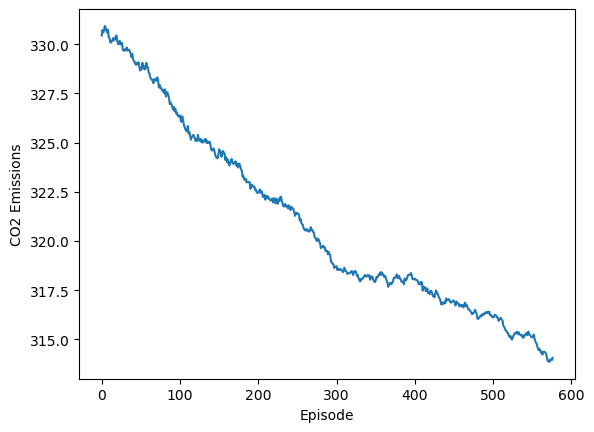

In [4]:
window_size = 30
running_avg = running_average(emissions_total, window_size)
plt.plot(running_avg)

plt.xlabel("Episode")
plt.ylabel("CO2 Emissions")
plt.savefig("emissions.pdf", format="pdf", bbox_inches="tight")
plt.show()

Text(0.5, 1.0, 'Approximated total travel time')

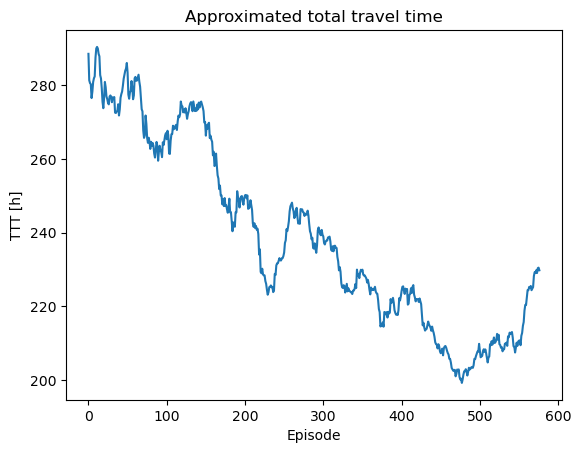

In [5]:
running_avg = running_average(TTTs, window_size)
plt.plot(running_avg)

plt.xlabel("Episode")
plt.ylabel("TTT [h]")
plt.title("Approximated total travel time")

In [6]:
with open(f"MARL_time_{B}_mix_{travel_time_weight}.pkl", "wb") as fp:  # Pickling
    pickle.dump(TTTs, fp)

with open(f"MARL_emissions_{B}_mix_{emisions_weight}.pkl", "wb") as fp:  # Pickling
    pickle.dump(emissions_total, fp)

In [7]:
with open("MARL_Emissions_time_10e3.pkl", "rb") as fp:  # Unpiclking
    TTTs = pickle.load(fp)

In [6]:
len(TTTs)

606

In [7]:
np.mean(TTTs[-100:])

213.35873611111114

In [8]:
np.mean(emissions_total[-100:])

314.1195406999999

In [ ]:
def run_duaIterate(iter, initial_routes):
    dua_iterate_command = [
        "python",
        "../Reinforcement Learning/KamppiNet/duaIterate.py",
        "-n",
        "kamppi.net.xml",
        "-r",
        initial_routes,
        "-l",
        str(iter),
        "-a",
        "500",
        "-E",
        "noSummary--routing-algorithm",
        "dijkstra",
        "--max-alternatives",
        "4",
        "--clean-alt",
        "--gzip",
    ]
    subprocess.call(dua_iterate_command)

    # Retrieve TTTs
    TTTs = []
    emissions = []
    for i in range(iter):
        n = str(i)
        tripinfo_file = "%s%s%s%s" % (n.zfill(3), "/tripinfo_", n.zfill(3), ".xml")
        TTTs.append(parse_tripinfo(tripinfo_file))

        fcd_file = "%s%s%s" % (n.zfill(3), "/fcd", ".xml")
        emissions.append(main(fcd_file))

    return TTTs, emissions


def parse_tripinfo(tripinfo_file):
    tree = ET.parse(tripinfo_file)
    root = tree.getroot()

    vehicle_travel_times = {}

    for tripinfo in root.findall("tripinfo"):
        vehicle_id = tripinfo.get("id")
        duration = float(tripinfo.get("duration"))
        vehicle_travel_times[vehicle_id] = duration

    TTT = sum(vehicle_travel_times.values())
    return TTT / 60**2


TTTs_baseline, emissions_baseline = run_duaIterate(
    1, "demo_361.rou.alt"
)  # (606, 'demo.rou.xml')
with open("duaIterate_time_2.pkl", "wb") as fp:  # Pickling
    pickle.dump(TTTs_baseline, fp)

with open("duaIterate_emissions_2.pkl", "wb") as fp:  # Pickling
    pickle.dump(emissions_baseline, fp)